## Encoder Example
  - A simple example of odometry estimation using wheel encoder 

In [1]:
!pip install evo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 7.6 MB/s eta 0:00:00
  Created wheel for evo: filename=evo-1.22.0-py3-none-any.whl size=132262 sha256=d8b4ecdf436d887dd2942f4b937da7b328b337b4fb95770d5b0dba62452aafb4
  Stored in directory: /root/.cache/pip/wheels/fd/f4/01/767a594be8c2eb4969482baabb61d56def3e38fcf3990bc230
Successfully built evo


In [2]:
!pip install spatialmath-python
!pip install roboticstoolbox-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for colored: filename=colored-1.4.4-py3-none-any.whl size=14268 sha256=85c29570ff3570fccde876f6ca1f003f985d2fe1a2b3b65fb09ceb5be5aaf6e0
  Stored in directory: /root/.cache/pip/wheels/7a/f5/27/54cfa98930f018369067d8d02e508e053b1fec3704c258916b
Successfully built colored
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 22.7 MB/s eta

In [3]:
from evo.tools import file_interface
import numpy as np
import spatialmath
from roboticstoolbox import quintic, trapezoidal, mtraj, mstraj, xplot, ctraj
import matplotlib.pyplot as plt


## single measurement example

 The travelled distance by each wheel is given by:
 
 $\Delta X = 2\pi R N_{ticks}/N_{total}$
 
 where,
   - $\Delta X$ is the distance travelled by each wheel   
   - $N_{ticks}$ is the number of ticks measured by each wheel   
   - $N_{total}$ is the number of ticks for a full revolution

In [ ]:
## Setting parameters
R = 0.0318     # meter
Ntotal = 135   # ticks
delta_t = 1    # second
w = .2         # distance of each wheel to the center
# Simulate velocities
A = np.array([[1, w],[1 ,-w]])
dx = 1
Nticks = dx/(2*np.pi*R/Ntotal) 
Nticks = np.floor(Nticks)
vx = (2*np.pi*R*Nticks/Ntotal)/delta_t
omega = np.deg2rad(0)  #rad/s
U = np.array( [[vx],[omega]])
vels = A@U
# Estimate
noise = 0*np.random.randn(2).reshape(2,1)
estimations = 0.5 * np.array([[1, 1],[1/w ,-1/w]]) @ (vels+noise) 

---------------------

### using trajectory

In [ ]:
N = 50
traj = mtraj(trapezoidal, [0, 0], [10, 10], N);

In [ ]:
estimations = np.zeros((N,2))
delta_t = 1#1/N
#deltas_x  = np.sqrt(np.sum((np.diff(traj.qd,axis=0).reshape(2,1))**2))
#deltas
for ii in range(N):
    noise =0*np.random.randn(2).reshape(2,1) * 0.1
    dx = np.sqrt(np.sum((traj.qd[ii,:].reshape(2,1))**2))
    Nticks = dx/(2*np.pi*R/Ntotal) 
    #print(Nticks)
    Nticks = np.floor(Nticks)
    #print(Nticks)
    vx = (2*np.pi*R*Nticks/Ntotal)/delta_t
    U=vx
    vels = (A@np.array([[U],[0]])) + noise
    estimations[ii,:] = (0.5 * np.array([[1, 1],[1/w ,-1/w]]) @ vels ).reshape(1,2)

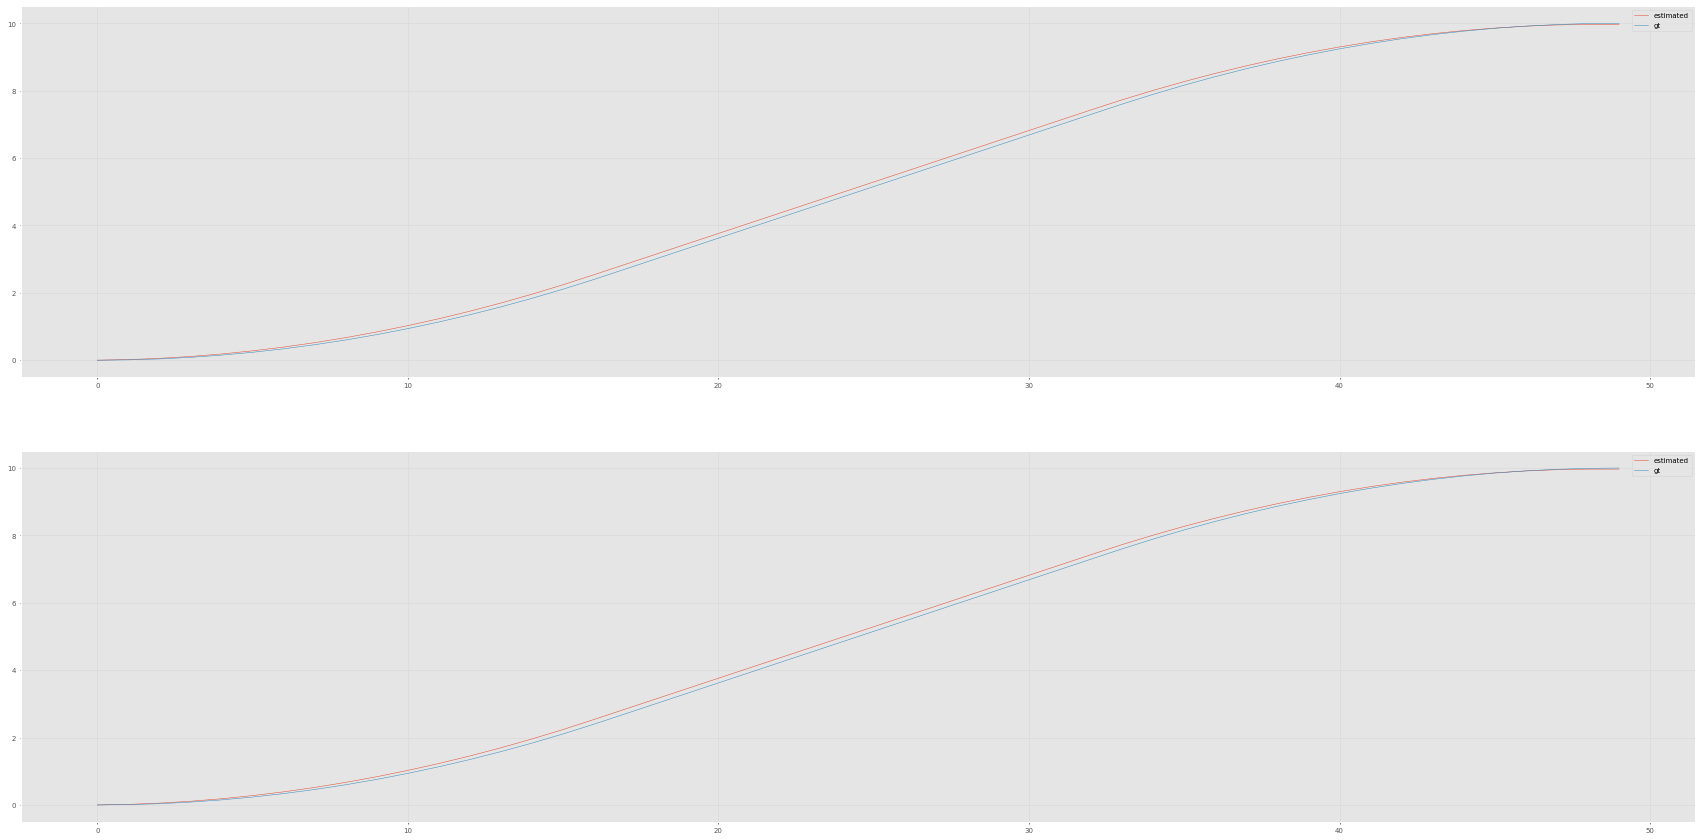

In [ ]:
initial_orientation = np.deg2rad(45)
phi = initial_orientation+estimations[:,1]
x_est = np.cumsum(estimations[:,0]*np.cos(phi))
y_est = np.cumsum(estimations[:,0]*np.sin(phi))
fig,ax = plt.subplots(2,figsize=(30,15))
ax[0].plot(x_est,label="estimated")
ax[1].plot(y_est,label="estimated")
ax[0].plot(traj.q[0:,0],label="gt")
ax[1].plot(traj.q[0:,1],label="gt")
for _ax in ax:
    _ax.legend()

## With noise

In [ ]:
estimations = np.zeros((N,2))
delta_t = 1/N
for ii in range(N):
    noise =1.5*np.random.randn(2).reshape(2,1) * 0.1 # change 0.1,1.5
    U = np.sqrt(np.sum((traj.qd[ii,:].reshape(2,1))**2))
    vels = (A@np.array([[U],[0]])) + noise
    estimations[ii,:] = (0.5 * np.array([[1, 1],[1/w ,-1/w]]) @ vels ).reshape(1,2)

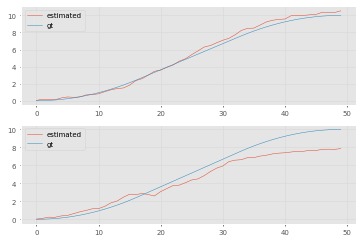

In [ ]:
initial_orientation = np.deg2rad(45)
phi = initial_orientation+estimations[:,1]
x_est = np.cumsum(estimations[:,0]*np.cos(phi))
y_est = np.cumsum(estimations[:,0]*np.sin(phi))
fig,ax = plt.subplots(2)
ax[0].plot(x_est,label="estimated")
ax[1].plot(y_est,label="estimated")
ax[0].plot(traj.q[:,0],label="gt")
ax[1].plot(traj.q[:,1],label="gt")
for _ax in ax:
    _ax.legend()

## Evaluate trajectory estimation

In [ ]:
from scipy.spatial.transform import Rotation 
import pandas as pd


### Prepare Gt

In [ ]:
angles = np.ones(len(traj.q)) * np.deg2rad(45)
for ii in range(len(traj.q)-1):
    angles[ii] = np.arctan2(np.diff(traj.q,axis=0)[ii][1],np.diff(traj.q,axis=0)[ii][0])
yaws_quat = Rotation.from_euler("z",angles)
yaws_quat = yaws_quat.as_quat()

In [ ]:
gt_temp_df = pd.DataFrame(columns = ("Time","tx","ty","tz",
                                                                       "qx","qy","qz","qw"))
for jj in range(len(traj.q)):
    qx,qy,qz,qw = yaws_quat[jj]
    gt_temp_df2 = pd.DataFrame((np.array([jj*delta_t,traj.q[jj,0],
                                          traj.q[jj,1],0,qx,qy,qz,qw
                                     ]))[np.newaxis,:],columns = ("Time","tx","ty","tz",
                                                                        "qx","qy","qz","qw"))
    gt_temp_df=gt_temp_df.append(gt_temp_df2)

<ipython-input-14-1c0edcaafc14>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gt_temp_df=gt_temp_df.append(gt_temp_df2)
<ipython-input-14-1c0edcaafc14>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gt_temp_df=gt_temp_df.append(gt_temp_df2)
<ipython-input-14-1c0edcaafc14>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gt_temp_df=gt_temp_df.append(gt_temp_df2)
<ipython-input-14-1c0edcaafc14>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gt_temp_df=gt_temp_df.append(gt_temp_df2)
<ipython-input-14-1c0edcaafc14>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [ ]:
# Save file as csv
gt_temp_df.to_csv(f"./gtpose_TUM.txt",sep=" ",header=False,columns=None,index=False)


In [ ]:
#Load using EVO
gt_evo = file_interface.read_tum_trajectory_file(f"./gtpose_TUM.txt")

### Prepare Estimations

In [ ]:
yaws_quat = Rotation.from_euler("z",phi)
yaws_quat = yaws_quat.as_quat()

In [ ]:
est_temp_df = pd.DataFrame(columns = ("Time","tx","ty","tz",
                                                                       "qx","qy","qz","qw"))
for jj in range(len(x_est)):
    qx,qy,qz,qw = yaws_quat[jj]
    est_temp_df2 = pd.DataFrame((np.array([jj*delta_t,x_est[jj],
                                          y_est[jj],0,qx,qy,qz,qw
                                     ]))[np.newaxis,:],columns = ("Time","tx","ty","tz",
                                                                        "qx","qy","qz","qw"))
    est_temp_df=est_temp_df.append(est_temp_df2)

<ipython-input-18-17bb46ad7b4b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  est_temp_df=est_temp_df.append(est_temp_df2)
<ipython-input-18-17bb46ad7b4b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  est_temp_df=est_temp_df.append(est_temp_df2)
<ipython-input-18-17bb46ad7b4b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  est_temp_df=est_temp_df.append(est_temp_df2)
<ipython-input-18-17bb46ad7b4b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  est_temp_df=est_temp_df.append(est_temp_df2)
<ipython-input-18-17bb46ad7b4b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

In [ ]:
# Save file as csv
est_temp_df.to_csv(f"./estpose_TUM.txt",sep=" ",header=False,columns=None,index=False)


In [ ]:
#Load using EVO
est_evo = file_interface.read_tum_trajectory_file(f"./estpose_TUM.txt")

## Estimate error

In [ ]:
from evo.core import sync
import copy
from evo.core import metrics
import pprint
from evo.tools import log
log.configure_logging()

from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS

Initialized new /root/.evo/settings.json


In [ ]:
use_aligned_trajectories = 0
TUM = 1
traj_ref = gt_evo
traj_est = est_evo
if TUM:
    max_diff = 0.1
    traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
if use_aligned_trajectories:
    traj_est_aligned = copy.deepcopy(traj_est)
    traj_est_aligned.align(traj_ref, correct_scale=True, correct_only_scale=False)
    data = (traj_ref,traj_est_aligned)
else:
    data = (traj_ref,traj_est)

In [ ]:
ape_stats = {}
pose_relation = metrics.PoseRelation.rotation_angle_deg
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats["rot. (degrees)"] = ape_metric.get_all_statistics()
#pprint.pprint(ape_stats)
#print("\n")
pose_relation = metrics.PoseRelation.rotation_angle_rad
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats["rot. (rad)"] = ape_metric.get_all_statistics()
#pprint.pprint(ape_stats)
#print("\n")
pose_relation = metrics.PoseRelation.translation_part
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats["transl. (met.)"] = ape_metric.get_all_statistics()
#pprint.pprint(ape_stats)

In [ ]:
ape_stats

{'rot. (degrees)': {'rmse': 0.0,
  'mean': 0.0,
  'median': 0.0,
  'std': 0.0,
  'min': 0.0,
  'max': 0.0,
  'sse': 0.0},
 'rot. (rad)': {'rmse': 0.0,
  'mean': 0.0,
  'median': 0.0,
  'std': 0.0,
  'min': 0.0,
  'max': 0.0,
  'sse': 0.0},
 'transl. (met.)': {'rmse': 0.14000682301753242,
  'mean': 0.12189995549145284,
  'median': 0.13658021485920707,
  'std': 0.0688644417870679,
  'min': 0.0,
  'max': 0.19859764240671854,
  'sse': 0.9800955245731323}}

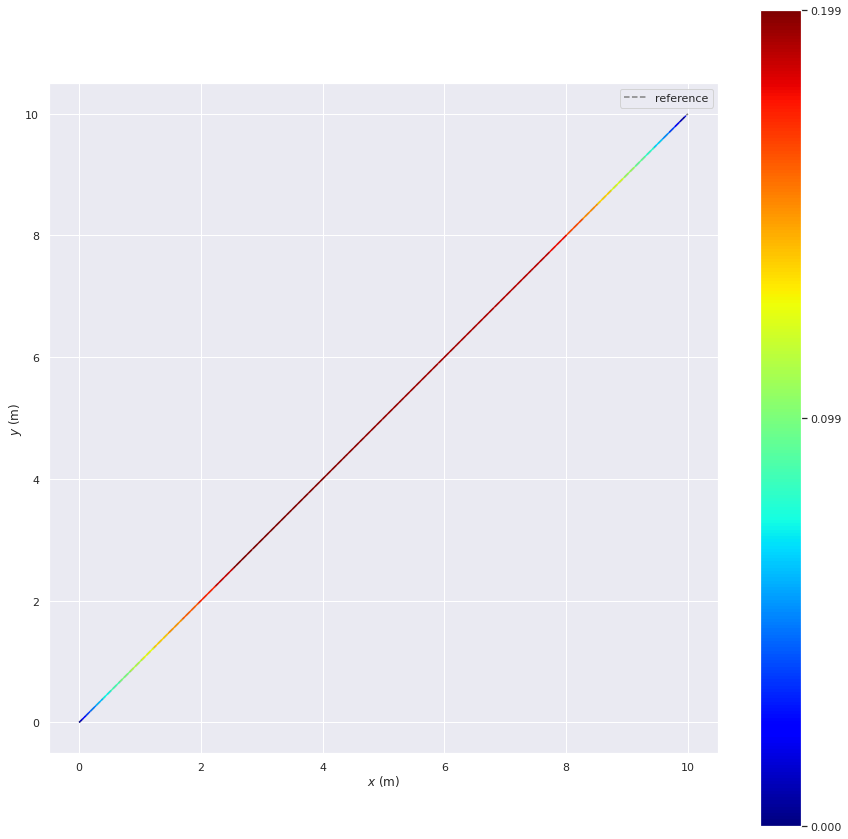

In [ ]:
ape_stats=ape_stats["transl. (met.)"]
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15,15))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()



In [ ]:
### RPE
rpe_stats ={}
# normal mode
delta = 1
delta_unit = metrics.Unit.frames

# all pairs mode
all_pairs = True  # activate

pose_relation = metrics.PoseRelation.rotation_angle_deg
rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
rpe_metric.process_data(data)


rpe_stats["rotation_deg"] = rpe_metric.get_all_statistics()
pose_relation = metrics.PoseRelation.translation_part
rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
rpe_metric.process_data(data)
rpe_stats["transl_met"] = rpe_metric.get_all_statistics()
#pprint.pprint(rpe_stats)

In [ ]:
rpe_stats

{'rotation_deg': {'rmse': 0.0,
  'mean': 0.0,
  'median': 0.0,
  'std': 0.0,
  'min': 0.0,
  'max': 0.0,
  'sse': 0.0},
 'transl_met': {'rmse': 0.01078932150901577,
  'mean': 0.00904974517431577,
  'median': 0.012313672369687834,
  'std': 0.005874654960494171,
  'min': 0.0007214545431728503,
  'max': 0.01472510974037533,
  'sse': 0.005704063472620606}}

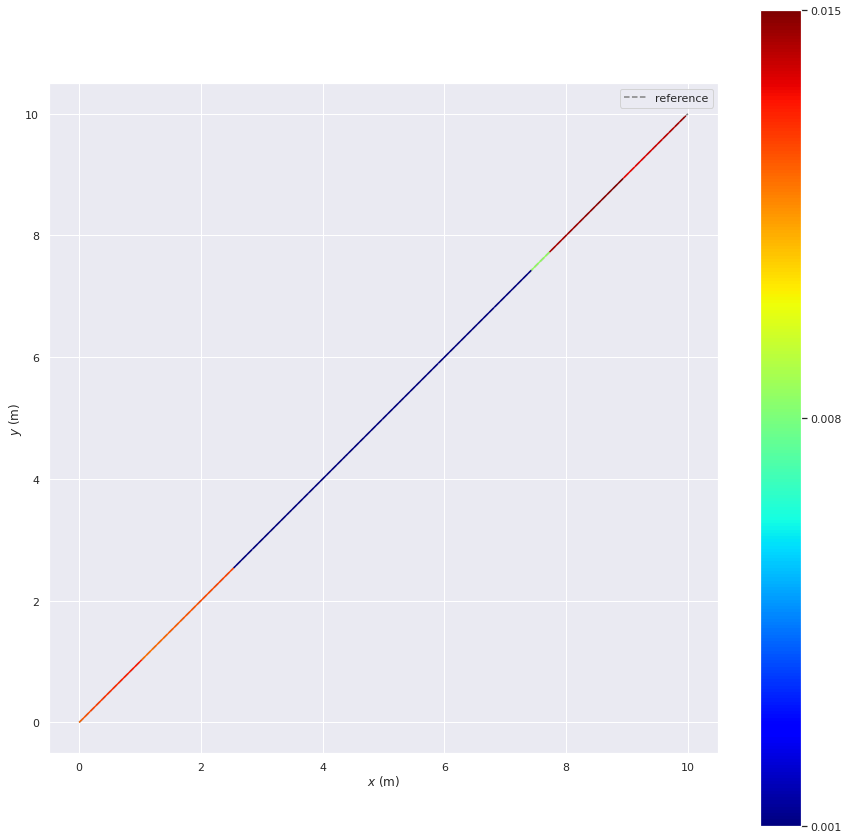

In [ ]:

rpe_stats = rpe_stats["transl_met"]
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15,15))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est, rpe_metric.error, plot_mode, min_map=rpe_stats["min"], max_map=rpe_stats["max"])
ax.legend()
plt.show()

